In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Definition of TES algorithm

In [ ]:
class HoltWinters:
    def __init__(self, alpha, beta, gamma,dampening, season_length,additive=False):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.dampening = dampening
        self.season_length = season_length
        self.additive = additive
    
    def fit_predict(self,Y, h):
        n = len(Y)
        L = np.zeros(n) # level array
        T = np.zeros(n) # trend array
        S = np.zeros(n) # seasonal array
        F = np.zeros(h) # forecast array

        # Initialize level, trend, and seasonal components
        L[0] = np.mean(Y[:self.season_length])
        T[0] = (np.mean(Y[self.season_length:2*self.season_length]) - L[0]) / self.season_length
        for i in range(self.season_length):
            S[i] = Y[i] / L[0]

        # Holt-Winters equations
        for t in range(self.season_length, n):
            if self.additive:
                L[t] = self.alpha * (Y[t] - S[t - self.season_length]) + (1 - self.alpha) * (L[t - 1] + self.dampening * T[t - 1])
                T[t] = self.beta * (L[t] - L[t - 1]) + (1 - self.beta) * self.dampening * T[t - 1]
                S[t] = self.gamma * (Y[t] - L[t]) + (1 - self.gamma) * S[t - self.season_length]
            else:    
                L[t] = self.alpha * (Y[t] / S[t - self.season_length]) + (1 - self.alpha) * (L[t - 1] + self.dampening * T[t - 1])
                T[t] = self.beta * (L[t] - L[t - 1]) + (1 - self.beta) * self.dampening * T[t - 1]
                S[t] = self.gamma * (Y[t] / L[t]) + (1 - self.gamma) * S[t - self.season_length]
            
        # Forecasting
        for t in range(h):
            if self.additive:
                F[t] = L[n - 1] + (t + 1) * T[-1] + S[n - self.season_length + t%self.season_length]
            else:
                F[t] = (L[n - 1] + (t + 1) * T[-1]) * S[n - self.season_length + t%self.season_length]  
        return F  

# Loading and splitting data

In [3]:
sales_data = pd.read_csv("data/train.csv")
sales_data

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
print("The stores in the datasets are:\n", sales_data['Store'].sort_values().unique())
print("\nThe departments in the datasets are:\n", sales_data['Dept'].sort_values().unique())

The stores in the datasets are:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]

The departments in the datasets are:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 65 67 71 72 74 77 78 79 80 81 82 83 85 87 90
 91 92 93 94 95 96 97 98 99]


In [136]:
# lets look at the amount of data for each store-department combination
counts_df = sales_data.groupby(['Store','Dept']).size().reset_index(name='Count')
counts_df

,Store,Dept,Count
0,1,1,143
1,1,2,143
2,1,3,143
3,1,4,143
4,1,5,143
...,...,...,...
3326,45,94,134
3327,45,95,143
3328,45,96,2
3329,45,97,143


For most of the combinations we have a complete dataset, however there are some exceptions for each store. Lets check the statistics for each store and compare

In [6]:
# statistics for each Store
counts_df.groupby('Store')['Count'].agg(['min','max','mean','median','std'])

,min,max,mean,median,std
Store,,,,,
1,3,143,133.038961,143.0,31.665788
2,2,143,131.256410,143.0,35.319483
3,1,143,125.500000,143.0,41.834011
4,1,143,131.692308,143.0,35.606547
5,1,143,124.986111,143.0,40.880621
6,2,143,132.610390,143.0,33.121052
7,1,143,128.447368,143.0,35.823045
8,3,143,130.197368,143.0,38.261563
9,2,143,121.465753,143.0,45.555547


We can see that some of the series have a very limited amount of data. In order to perform TES we would need to have at least 52 weeks of data for the initialization and 4 weeks for forecasting. Lets see which store has the least amount of departments we can drop.

In [7]:
counts_df[counts_df['Count'] >= 56].groupby('Store')['Count'].count().sort_values(ascending=False).head(5)

Store
13    74
10    73
34    73
2     72
6     72
Name: Count, dtype: int64

We'll use data only for store 13 moving forward. We'll also drop the departments with less than 56 data points.

In [8]:
departments_to_use = counts_df[(counts_df['Count'] >= 56) & (counts_df['Store'] == 13)]['Dept'].unique()

In [133]:
sales_data_filtered = sales_data[(sales_data['Store'] == 13) & (sales_data['Dept'].isin(departments_to_use))].sort_values(by=['Store', 'Dept', 'Date'])
sales_series_df = pd.concat(
    {
        f'13-{dept}': sales_data_filtered[sales_data_filtered['Dept'] == dept][['Weekly_Sales','Date']].rename(columns={'Weekly_Sales': 'sales'}).set_index('Date')['sales']
        for dept in departments_to_use
    },
    axis=1
)
sales_series_df

,13-1,13-2,13-3,13-4,13-5,13-6,13-7,13-8,13-9,13-10,...,13-87,13-90,13-91,13-92,13-93,13-94,13-95,13-96,13-97,13-98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,46761.90,75275.87,21946.62,42482.68,53089.80,7008.52,35711.89,40372.38,26597.10,22422.77,...,13482.46,111718.02,89955.29,166872.27,43732.99,70677.59,125740.33,7508.13,24823.33,15204.21
2010-02-12,78415.94,71615.26,20253.53,39171.36,61254.59,8577.49,42860.17,37958.97,24131.97,24505.74,...,12323.95,104969.16,86593.72,153435.29,43259.13,73423.15,126969.69,10321.65,24338.35,20456.63
2010-02-19,44042.19,73914.37,18035.33,38877.77,53963.19,9955.91,42031.02,36753.34,31939.87,25112.67,...,11417.84,109374.20,90037.67,157625.49,46607.26,89971.83,117103.87,8087.74,25077.71,16289.94
2010-02-26,31574.04,74581.56,19959.10,37759.08,49299.78,7931.88,37361.68,36803.99,24678.08,23903.44,...,14610.08,102986.93,81456.01,149088.91,40514.72,69513.71,117729.38,7577.15,22216.51,14413.38
2010-03-05,34505.07,77597.26,18621.56,41168.21,51801.69,8964.56,43562.70,38669.87,28922.35,25934.84,...,12130.27,108390.05,86624.04,160382.53,44339.82,71558.59,127070.87,7620.39,24505.34,14791.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,36678.66,75530.96,17841.83,42380.96,72284.15,5247.72,43144.88,35900.68,34329.15,29102.64,...,19196.33,120890.02,78123.05,169014.00,48095.85,74522.20,134396.52,9154.16,28536.69,15828.34
2012-10-05,44180.86,80908.63,18935.14,46983.08,52946.20,3645.15,42023.13,40622.54,43725.28,31352.86,...,20950.30,130632.28,83424.44,181471.61,54069.81,76432.82,140831.65,9884.46,31728.19,15409.98
2012-10-12,47496.96,75251.48,17063.93,42528.42,48423.13,5531.74,37473.65,38694.16,30509.48,33092.88,...,19581.51,129858.28,84162.87,184760.29,52631.16,77522.15,135555.41,9325.61,30137.65,15246.41


## Data augmentation

During testing, we found 2 departments (13-45 and 13-51) that have outlier values. There is also the problem if missing weeks within a few of the departments. We will impute the missing data with 1-year old information if available and linear interpolation when not possible.

In [140]:
sales_series_df = sales_series_df.fillna(sales_series_df.shift(52)).interpolate(method='linear')
sales_series_df.isna().sum()

13-1     0
13-2     0
13-3     0
13-4     0
13-5     0
        ..
13-94    0
13-95    0
13-96    0
13-97    0
13-98    0
Length: 74, dtype: int64

However, there is still a single 0 value in the 13-45 department that results in an incorrect division. Looking at the data, the date (2010-06-25) is not a holiday so it must be an outlier within the data itself. We can also notice that, ignoring this value, the soft lower bound of the data is somewhere around 5.5. We will change this value to 5 to preserve the model's numerical calculations.

In [145]:
sales_series_df.loc[sales_series_df.index == '2010-06-25','13-45'] = 5

The data for department 13-51 contains negative values which should be impossible for sales data. We can shift everything to above 0 and see if that helps out the model.

In [154]:
sales_series_df['13-51'] = sales_series_df['13-51'] + (1 - sales_series_df['13-51'].min())

## Sanity check if everything so far works.

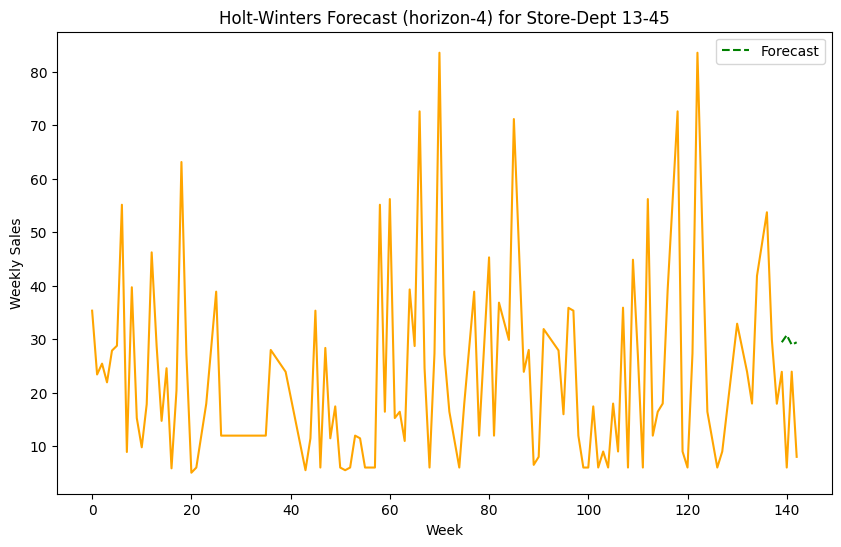

In [200]:
key = '13-45'
series = sales_series_df[key]
tes = HoltWinters(
    alpha=0.1,
    beta=0.01,
    gamma=0.1,
    dampening=1.0,
    season_length=52,
    additive=True
)
fcs = tes.fit_predict(series.values[:-4], h=4)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)), series.values, color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast (horizon-4) for Store-Dept {key}')
plt.legend()
plt.show()

# Method 1: Per item forecasting

## Forecasting and parameters optimization

In [167]:
def forecast(series, h, alpha, beta, gamma,additive=False):
    model = HoltWinters(
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        dampening=1.0,
        season_length=52,
        additive=additive
    )
    """Forecasts the given time series with horizon-1 for the last h points of the data using the Holt-Winters method."""
    fcs = np.zeros(h)
    for horizon in range(1,h+1):
        fcs[horizon-1] = model.fit_predict(series.values[:-(h+1-horizon)], h=1)[0]
    return fcs

### Horizon-1 forecasts example

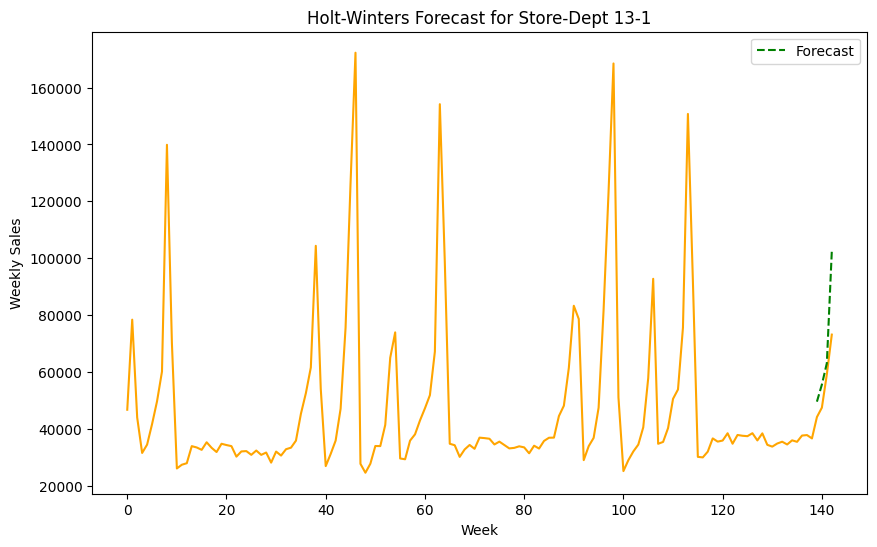

In [201]:
key = '13-1'
series = sales_series_df[key]
h = 4
fcs = forecast(series, h, alpha=0.2, beta=0.1, gamma=0.1)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)), series.values, color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

### Grid search example

In [191]:
#KPIs
def mape(real,predicted):
    return np.mean(
        np.abs(
            np.array(real)-np.array(predicted)
            )
        ) / np.sum(real) * 100
def mse(real,predicted):
    return np.mean(
        (np.array(real) - np.array(predicted))**2
    ) / len(real)
def mae(real,predicted):
    return np.mean(
        np.abs(np.array(real)-np.array(predicted))
    ) / len(real)
def rmse(real,predicted):
    return np.sqrt(mse(real,predicted))

In [192]:
def grid_search(series, h, alpha_values, beta_values, gamma_values,additive=False,tqdm_disable=False):
    
    best_params = (None, None, None)
    best_mse = float('inf')
    best_mae = float('inf')
    best_mape = float('inf')
    
    for alpha in tqdm(alpha_values,disable=tqdm_disable):
        for beta in beta_values:
            for gamma in gamma_values:
                fcs = forecast(series, h, alpha, beta, gamma, additive=additive)
                actuals = series.values[-h:]
                cur_mape = mape(actuals,fcs)
                cur_mse = mse(actuals,fcs)
                cur_mae = mae(actuals,fcs)
                if cur_mape < best_mape:
                    best_mape = cur_mape
                    best_mse = cur_mse
                    best_mae = cur_mae
                    best_params = (alpha, beta, gamma)
                    
    return best_params, best_mse,best_mae, best_mape

#### Multiplicative

100%|██████████| 19/19 [00:03<00:00,  6.15it/s]

Best Parameters: alpha=0.15000000000000002, beta=0.15000000000000002, gamma=0.9500000000000001
Best MSE: 1241801.131159699 | Best MAE: 466.66469553334264 | Best mape: 0.83%


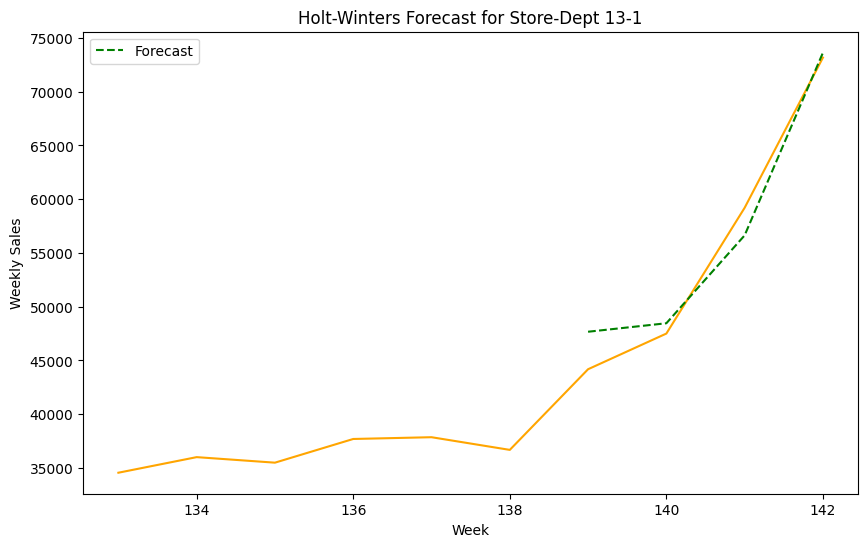

In [197]:
key = '13-1'
series = sales_series_df[key]
h = 4
additive=False
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=additive)
print(f"Best Parameters: alpha={params_mult[0]}, beta={params_mult[1]}, gamma={params_mult[2]}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best mape: {mape_mult:0.2f}%")
fcs = forecast(series, h, params_mult[0], params_mult[1], params_mult[2], additive=additive)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series.values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

#### Additive

100%|██████████| 19/19 [00:02<00:00,  6.63it/s]

Best Parameters: alpha=0.2, beta=0.35000000000000003, gamma=0.9500000000000001
Best MSE: 247031.83987202228 | Best MAE: 215.97198168072964 | Best MAPE: 0.39%


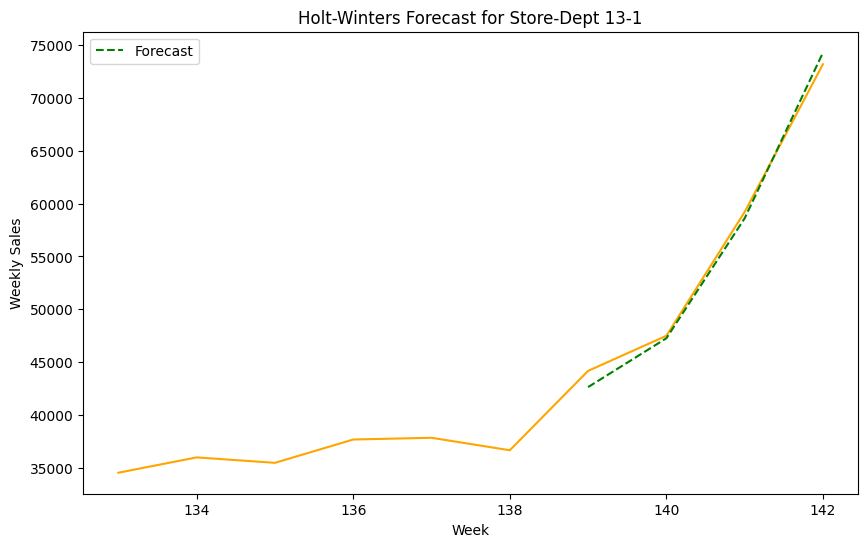

In [196]:
key = '13-1'
series = sales_series_df[key]
h = 4
additive=True
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=additive)
print(f"Best Parameters: alpha={params_mult[0]}, beta={params_mult[1]}, gamma={params_mult[2]}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")
fcs = forecast(series, h, params_mult[0], params_mult[1], params_mult[2], additive=additive)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series.values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

In this case (store 13, department 1) we can see that additive TES performs better, however there are some cases where the opposite might be true.

In [202]:
key = '13-23'
series = sales_series_df[key]
h = 4
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_additive, mse_additive, mae_additive, mape_additive = grid_search(series,h, alpha, beta, gamma, additive=True)
print(f"Best Parameters for additive: alpha={params_additive[0]:0.2f}, beta={params_additive[1]:0.2f}, gamma={params_additive[2]:0.2f}")
print(f"Best MSE: {mse_additive} | Best MAE: {mae_additive} | Best MAPE: {mape_additive:0.2f}%")
params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=False)
print(f"Best Parameters for multiplicative: alpha={params_mult[0]:0.2f}, beta={params_mult[1]:0.2f}, gamma={params_mult[2]:0.2f}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")

100%|██████████| 19/19 [00:02<00:00,  6.69it/s]


Best Parameters for additive: alpha=0.05, beta=0.15, gamma=0.95
Best MSE: 2385058.4792812355 | Best MAE: 582.5137964605435 | Best MAPE: 1.84%


100%|██████████| 19/19 [00:02<00:00,  6.52it/s]

Best Parameters for multiplicative: alpha=0.10, beta=0.55, gamma=0.25
Best MSE: 100116.2919377361 | Best MAE: 125.93638734212254 | Best MAPE: 0.40%


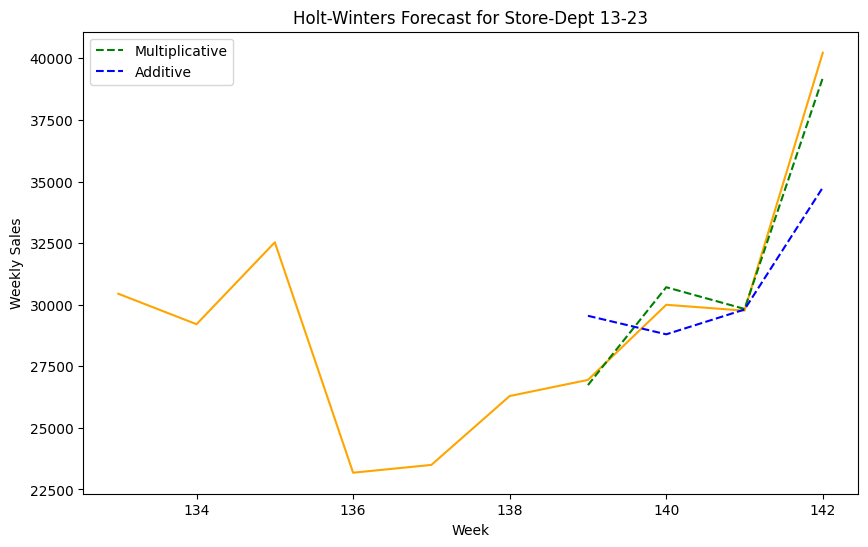

In [204]:
fcs_mult= forecast(series, h, params_mult[0], params_mult[1], params_mult[2], additive=False)
fcs_add= forecast(series, h, params_additive[0], params_additive[1], params_additive[2], additive=True)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series.values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs_mult, label='Multiplicative', color='green', linestyle='--')
plt.plot(range(len(series)-4,len(series)), fcs_add, label='Additive', color='blue', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

## Finding best parameter per store-department combination

In [205]:
alphas = dict()
betas = dict()
gammas = dict()
mses = dict()
maes = dict()
mapes = dict()
additives = dict()
# for key in tqdm(['13-1','13-23','13-33','13-35','13-13']):
for key in tqdm(sales_series_df.columns):
    series = sales_series_df[key]
    h = 4
    alpha = np.arange(0.05, 1.0, 0.05)
    beta = np.arange(0.05, 1.0, 0.05)
    gamma = np.arange(0.05, 1.0, 0.05)
    params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=False,tqdm_disable=True)
    params_add, mse_add, mae_add, mape_add = grid_search(series,h, alpha, beta, gamma, additive=True,tqdm_disable=True)
    if mape_mult < mape_add:
        alphas[key] = params_mult[0]
        betas[key] = params_mult[1]
        gammas[key] = params_mult[2]
        mses[key] = mse_mult
        maes[key] = mae_mult
        mapes[key] = mape_mult
        additives[key] = False
    else:
        alphas[key] = params_add[0]
        betas[key] = params_add[1]
        gammas[key] = params_add[2]
        mses[key] = mse_add
        maes[key] = mae_add
        mapes[key] = mape_add
        additives[key] = True
        
best_params_df = pd.DataFrame({
    'dept': {key: key.split('-')[1] for key in sales_series_df.columns},
    'alpha': alphas,
    'beta': betas,
    'gamma': gammas,
    'mse': mses,
    'mae': maes,
    'mape': mapes,
    'additive': additives
    })
#save for later use
best_params_df.reset_index().drop(columns=['index']).to_csv("holt_winters_best_params.csv",index=False)

100%|██████████| 74/74 [05:54<00:00,  4.80s/it]


instead of running every time, we can load already saved dataframe

In [206]:
best_params_df = pd.read_csv("holt_winters_best_params.csv")
best_params_df.sort_values(by='mape',ascending=False)

,dept,alpha,beta,gamma,mse,mae,mape,additive
41,45,0.05,0.65,0.25,2.424640e+01,1.882277,12.196841,True
52,59,0.05,0.05,0.25,4.356582e+03,23.161038,6.779469,True
48,54,0.05,0.25,0.05,4.049111e+01,2.361378,6.608027,True
29,31,0.05,0.15,0.10,3.901346e+05,212.133911,4.753903,False
23,25,0.05,0.15,0.05,4.655336e+06,707.885685,3.970879,False
...,...,...,...,...,...,...,...,...
65,90,0.05,0.40,0.20,1.987784e+05,205.056527,0.158020,True
1,2,0.30,0.40,0.70,5.779202e+04,86.250598,0.113860,True
70,95,0.20,0.25,0.55,1.533774e+05,148.197205,0.109457,False
60,81,0.05,0.05,0.25,7.818584e+03,32.377340,0.096811,True


# Method 2: Aggregated data forecasting

## Aggregating by store

We will add all departments within one store and forecast on the aggregated data. This will yield a single prediction for the sales of the whole store, which we would need to de-aggregated afterwards to get predictions for each department within. In order to do this we will keep weights for each department's contribution.

In [213]:
# adding all departments into a single timeseries
agg_data = sales_series_df.sum(axis=1).rename('sales')

#calculating department weights for later deaggregation
departments_weights = sales_series_df.sum() / sales_series_df.sum().sum()

Visualizing the aggregated data

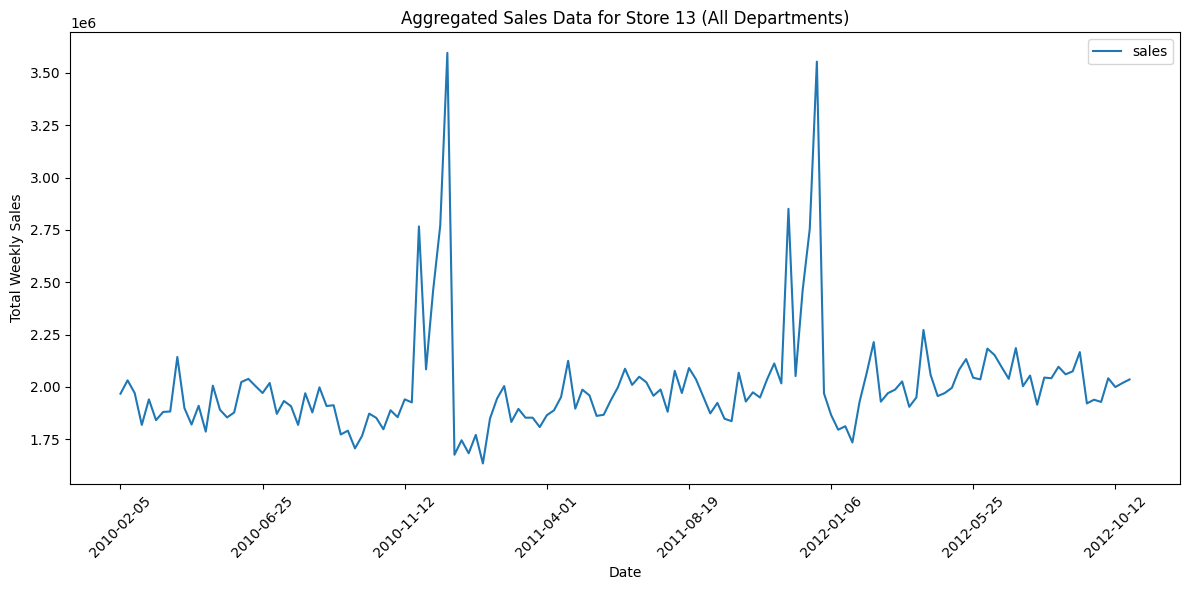

In [209]:
agg_data.plot(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Aggregated Sales Data for Store 13 (All Departments)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Using grid search to find the best model parameters

In [215]:
h = 4
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_additive, mse_additive, mae_additive, mape_additive = grid_search(agg_data,h, alpha, beta, gamma, additive=True)
params_mult, mse_mult, mae_mult, mape_mult = grid_search(agg_data,h, alpha, beta, gamma, additive=False)

100%|██████████| 19/19 [00:02<00:00,  6.56it/s]


In [216]:
print(f"Best Parameters for additive: alpha={params_additive[0]:0.2f}, beta={params_additive[1]:0.2f}, gamma={params_additive[2]:0.2f}")
print(f"Best MSE: {mse_additive} | Best MAE: {mae_additive} | Best MAPE: {mape_additive:0.2f}%")
print(f"Best Parameters for multiplicative: alpha={params_mult[0]:0.2f}, beta={params_mult[1]:0.2f}, gamma={params_mult[2]:0.2f}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")

Best Parameters for additive: alpha=0.10, beta=0.05, gamma=0.20
Best MSE: 30399340.91904807 | Best MAE: 2346.187212202436 | Best MAPE: 0.12%
Best Parameters for multiplicative: alpha=0.20, beta=0.25, gamma=0.75
Best MSE: 148213852.54756805 | Best MAE: 4468.783444833185 | Best MAPE: 0.22%


Additive TES performs better on the aggregated data so we will use it for comparison with per-item forecasts.

# Comparison between unit-level and aggregated forecasting

In [218]:
# calculating forecasts for all departments based on best parameters found earlier
unit_fcs = dict()
for dept in tqdm(departments_to_use):
    series = sales_series_df[f'13-{dept}']
    unit_fcs[f'13-{dept}'] = forecast(series, 4, best_params_df.loc[best_params_df['dept']==dept, 'alpha'].values[0],
                        best_params_df.loc[best_params_df['dept']==dept, 'beta'].values[0],
                        best_params_df.loc[best_params_df['dept']==dept, 'gamma'].values[0],
                        additive=best_params_df.loc[best_params_df['dept']==dept, 'additive'].values[0]
                        )

100%|██████████| 74/74 [00:00<00:00, 898.93it/s]


In [219]:
# deaggregating forecasts
agg_fcs = forecast(agg_data,h=4,alpha=0.1,beta=0.05,gamma=0.2,additive=True)
agg_fcs = {
    dept : agg_fcs * departments_weights[dept] for dept in departments_weights.index
}

# combining into a dataframe for easier use
real_values = {dept: sales_series_df.iloc[-4:][dept].values.tolist() for dept in sales_series_df.columns}
results_df =pd.DataFrame({
    "unit" : unit_fcs,
    "agg" : agg_fcs,
    "real" : real_values
})

In [220]:
metrics_df = pd.DataFrame({
    'dept': results_df.index,
    'unit_mape': [mape(results_df.loc[dept, 'real'], results_df.loc[dept, 'unit']) for dept in results_df.index],
    'unit_rmse': [rmse(results_df.loc[dept, 'real'], results_df.loc[dept, 'unit']) for dept in results_df.index],
    'agg_mape': [mape(results_df.loc[dept, 'real'], results_df.loc[dept, 'agg']) for dept in results_df.index],
    'agg_rmse': [rmse(results_df.loc[dept, 'real'], results_df.loc[dept, 'agg']) for dept in results_df.index]
})
metrics_df.sort_values(by='unit_mape',ascending=False)

,dept,unit_mape,unit_rmse,agg_mape,agg_rmse
41,13-45,12.196841,4.924063,13.680742,5.945265
52,13-59,6.779469,66.004411,73.225640,502.859715
48,13-54,6.608027,6.363263,56.913111,41.167458
29,13-31,4.753903,624.607529,6.851578,884.631539
23,13-25,3.970879,2157.622753,5.562982,3254.290585
...,...,...,...,...,...
65,13-90,0.158020,445.845678,2.488207,6472.720632
1,13-2,0.113860,240.399703,0.996225,1657.081589
70,13-95,0.109457,391.634310,0.684453,2752.585990
60,13-81,0.096811,88.422757,0.309925,291.548024


# TODO!: Analysis of result differences